In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

videofile = './Novgorod_2019-04-05-15_15_00.mp4'

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)

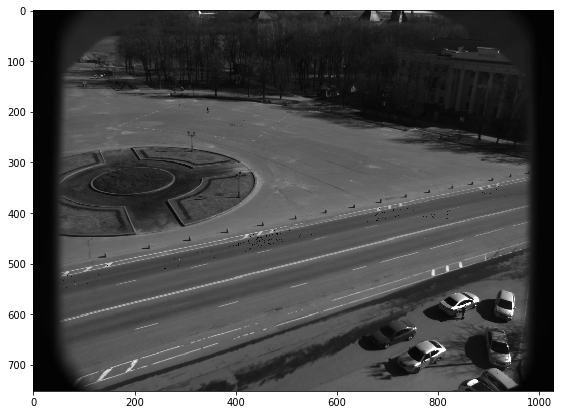

In [374]:
def get_background(filename, iters=10):
    cap = cv2.VideoCapture(filename)
    _, frame_1 = cap.read()
    frame_1 = cv2.resize(frame_1, dsize=tuple(np.array(frame_1.shape[:2][::-1])//4))
    background = frame_1
    for _ in range(iters-1):
        ret, frame_2 = cap.read()
        frame_2 = cv2.resize(frame_2, dsize=tuple(np.array(frame_2.shape[:2][::-1])//4))
        if not ret:
            return background
        
        background = np.where(frame_1 == frame_2, frame_1, background)
        frame_1 = frame_2

    cap.release()
    return background

bg = get_background(videofile, 70)
plt.imshow(bg)

In [15]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)

def detect_vehicles(fg_mask, min_contour_width=35, min_contour_height=35):

    saved_contours = list()
    centers = list()
    bbox = list()

    # finding external contours
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    # filtering by with, height
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        tmp_xywh = np.array(x,y,w,h)
        tmp_xywh[2:4] += tmp_xywh[0:2]
        bbox.append(tmp_xywh)
        if w < min_contour_width or h < min_contour_height:
            continue
        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)
        saved_contours.append(contour)
        centers.append(centroid)
    return saved_contours, centers, bbox


In [38]:
class Tracks():
    def __init__(self, center_rad=1, frame_offset=50, frame_size=None):
        self.count = 0
        self.center_rad = center_rad
        self.frame_size = frame_size
        self.frame_offset = frame_offset
        self.saved = dict()
        
    def __getitem__(self, key):
        return self.saved[key]
    
    def add_object(self, center, contour):
        new_idx = self.count
        self.saved[new_idx] = {
            'center': center,
            'contour': contour,
            'color': (np.random.randint(50, 240), np.random.randint(50, 240), np.random.randint(50, 240))
        }
        self.count += 1
    
    def update(self, centers, contours):
        if len(contours) != len(centers):
            raise ValueError("Sizes of contours and centers must be same!")
#         print("Updating...")
        saved = self.saved.copy()
        for idx in range(len(contours)):
            # check if object in tracking
            updated = False
            
            for saved_idx in saved:
                # if in radius, update
                x_diff = np.abs(centers[idx][0] - saved[saved_idx]['center'][0])
                y_diff = np.abs(centers[idx][1] - saved[saved_idx]['center'][1])
                if x_diff < self.center_rad or y_diff < self.center_rad:
                    updated = True
                    self.saved[saved_idx]['center'] = centers[idx]
                    self.saved[saved_idx]['contour'] = contours[idx]
                    print("Updated")
                    break
            if not updated:
                # else add to tracking
                self.add_object(centers[idx], contours[idx])
                print("Added")
        
        saved = self.saved.copy() 
        # removing old
        for saved_idx in saved:
            if self.saved[saved_idx]['center'][0] < self.frame_offset or \
               self.saved[saved_idx]['center'][0] > self.frame_size[0] - self.frame_offset or \
               self.saved[saved_idx]['center'][1] < self.frame_offset or \
               self.saved[saved_idx]['center'][1] > self.frame_size[1] - self.frame_offset:
                self.saved.pop(saved_idx)
                print("removed")
        print("-"*10)
    
    def draw_boxes(self, frame):
        frame_with_bords = frame
        for idx in self.saved:
            box = np.int0(cv2.boxPoints(cv2.minAreaRect(self.saved[idx]['contour'])))
    #         print(box)
            frame_with_bords = cv2.drawContours(frame_with_bords.copy(), [box], 0, self.saved[idx]['color'], 2)
        return frame_with_bords

In [39]:
import traceback
from sys import exc_info
from time import sleep

cap = cv2.VideoCapture(videofile)
tracks = Tracks(center_rad=10, frame_offset=50)
while cap.isOpened():
    try:
        ret, frame = cap.read()
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q') or not ret:
            cv2.destroyAllWindows()
            cap.release()
            break
        
        new_size = tuple((np.array(frame.shape[:2][::-1])/10).astype(np.int16))
        frame = cv2.resize(frame, dsize=new_size)
        
        threshed = (cv2.bitwise_xor(bg, frame)[:,:,0] > 50).astype(np.uint8)
        threshed = cv2.medianBlur(threshed, 7)
        
        contours, centers = detect_vehicles(threshed, 10, 12)
        print(f"Founded {len(contours)}")
        tracks.frame_size = new_size
        tracks.update(centers, contours)

        frame_with_tracks = tracks.draw_boxes(frame.copy())
        centers = [cv2.KeyPoint(*x, 5) for x in centers]
        frame_with_tracks = cv2.drawKeypoints(frame_with_tracks, centers, np.array([]), (0,255,0), 
                                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cv2.imshow('video', frame_with_tracks)
        sleep(0.1)

    except Exception as e:
        exc_info = exc_info()
        traceback.print_exception(*exc_info)
        cv2.destroyAllWindows()
        break
print(f"Finished. Detected {tracks.count} cars")
cap.release()

Founded 3
Added
Added
Added
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Added
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 4
Updated
Updated
Updated
Updated
----------
Founded 3
Updated
Updated
Updated
removed
----------
Founded 3
Added
Updated
Updated
removed
----------
Founded 3
Updated
Updated
Updated
----------
Founded 2
Updated
Updated
----------
Founded 2
Updated
Updated
----------
Founded 3
Added
Updated
Updated
removed
----------
Founded 3
Added
Updated
Updated
removed
----------
Founded 2
Updated
Updated
removed
----------
Founded 2
Added
Updated
removed
----------
Founded 2
Added
Updated
removed
----------
Founded 2
Added
Updated
remove

In [70]:
from keras.models import load_model

import cv2 as cv
clf = load_model('car_clf9.model')
classes = ['motorcycle',
 'pickup_truck',
 'car',
 'work_van',
 'articulated_truck',
 'single_unit_truck',
 'bus']

C:\Users\Alexey\Miniconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [367]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)

def detect_vehicles(fg_mask, size_thres):

    saved_masks = list()
    centers = list()
    bbox = list()

    # finding masks
    labels_cnt, masks = cv2.connectedComponents(threshed)
    labels, cnt = np.unique(masks, return_counts=True)

    # filtering by width, height
    for i in range(labels_cnt):
        if cnt[i] < size_thres:
            continue
        mask = (masks==i).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(mask)
        tmp_xywh = np.array([x,y,w,h], dtype=np.float16)
        tmp_xywh[2:4] += tmp_xywh[0:2]
        tmp_xywh = list(tmp_xywh)
        tmp_xywh += [1]
        bbox.append(tmp_xywh)
        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)
        saved_masks.append(mask)
        centers.append(centroid)
    return saved_masks, centers, bbox


In [376]:
def square_resize(frame_orig, tracker, k):
    h = np.abs(tracker[1]*k - tracker[3]*k)
    w = np.abs(tracker[0]*k - tracker[2]*k)
    
    expand_half = np.abs(w-h)//2
    if w>h:
        return frame_orig[tracker[1]*k-expand_half:tracker[3]*k+expand_half, tracker[0]*k:tracker[2]*k]
    else:
        return frame_orig[tracker[1]*k:tracker[3]*k, tracker[0]*k-expand_half:tracker[2]*k+expand_half]

In [384]:
import traceback
from sys import exc_info
from time import sleep
from sort.sort import Sort

mot_tracker = Sort()
classes_distr = {
    classes[0]: 0,
    classes[1]: 0,
    classes[2]: 0,
    classes[3]: 0,
    classes[4]: 0,
    classes[5]: 0,
    classes[6]: 0,
}
classes_pict = {
    classes[0]: [],
    classes[1]: [],
    classes[2]: [],
    classes[3]: [],
    classes[4]: [],
    classes[5]: [],
    classes[6]: [],
}
cap = cv2.VideoCapture(videofile)
colors = dict()
while cap.isOpened():
    try:
        ret, frame = cap.read()
        frame_orig = frame.copy()
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q') or not ret:
            cv2.destroyAllWindows()
            cap.release()
            break
        
        new_size = tuple((np.array(frame.shape[:2][::-1])//4).astype(np.int16))
        frame = cv2.resize(frame, dsize=new_size)
        
        threshed = (cv2.bitwise_xor(bg, frame) > 60)[:,:,0].astype(np.uint8)
        threshed = cv2.medianBlur(threshed*255, 7)
        
        masks, centers, bboxes = detect_vehicles(threshed, size_thres=600)
        bboxes = np.array(bboxes)
        trackers = mot_tracker.update(bboxes)
        
        for tracker in trackers:
            idx = tracker[4]
            tracker = tracker.astype(np.int32)
            if idx not in colors:
                x = square_resize(frame_orig, tracker, 4)
                x = cv.resize(x, dsize=(224,224))
                x = np.expand_dims(x, 0)/255
                probs = clf.predict(x)
                cls = classes[np.argmax(probs)]
                classes_distr[cls] += 1
                classes_pict[cls].append(x[0])
                
                colors[idx] = (np.random.randint(50, 240), np.random.randint(50, 240), np.random.randint(50, 240))
            frame = cv2.rectangle(frame,tuple(tracker[:2]),tuple(tracker[2:4]),colors[idx],2)

        cv2.imshow('video', threshed)
        sleep(0.5)

    except Exception as e:
        exc_info = exc_info()
        traceback.print_exception(*exc_info)
        cv2.destroyAllWindows()
        break
print(f"Finished. Detected {len(colors)} cars")
cap.release()

Finished. Detected 7 cars


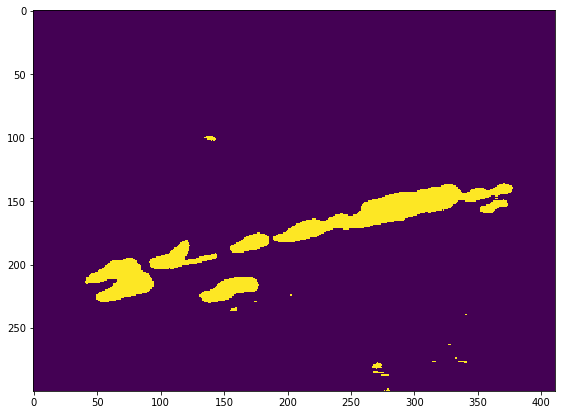

In [321]:
plt.imshow(threshed)

In [366]:
classes_distr

{'articulated_truck': 10,
 'bus': 5,
 'car': 61,
 'motorcycle': 2,
 'pickup_truck': 2,
 'single_unit_truck': 1,
 'work_van': 34}

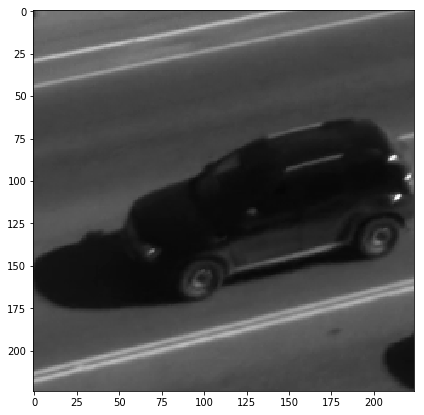

In [320]:
plt.imshow(classes_pict['pickup_truck'][2])